In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from Operator import Operator
from solve import fit_c, solve, measure

from utils import print_state


In [36]:
# 0. define `build_B` function
# below function builds :
#   a[0] * O[2,2] + a[1] * O[2,0]
# + a[2] * O[4,4] + a[3] * O[4,2]
# + a[4] * O[4,0] + a[5] * O[6,6] + a[6] * O[6,4] + a[7] * O[6,2] + a[8] * O[6,0]

def build_B(a):
    r"""
    build the coefficient for steven operators O[l,m]


    Args:
        a (torch.Tensor): initial parameters to construct

    Returns:
        B2 (torch.Tensor): coefficient for O[2,2],O[2,1],O[2,0],O[2,-1],O[2,-2]
        B4 (torch.Tensor): coefficient for O[4,4],O[4,3],O[4,2],O[4,1],O[4,0],O[4,-1],O[4,-2],O[4,-3],O[4,-4]
        B6 (torch.Tensor): coefficient for O[6,6],O[6,5],O[6,4],O[6,3],O[6,2],O[6,1],O[6,0],O[6,-1],O[6,-2],O[6,-3],O[6,-4],O[6,-5],O[6,-6]
    """
    zero = torch.tensor(0.0)

    B2 = torch.stack([a[0], zero, a[1], zero, zero])
    B4 = torch.stack([a[2], zero, a[3], zero, a[4], zero, zero, zero, zero])
    B6 = torch.stack([a[5], zero, a[6], zero, a[7], zero, a[8], zero, zero, zero, zero, zero, zero])

    return B2, B4, B6

In [37]:
# 1. define steven operators
spin=4.5
op = Operator(spin)

# 2. load experiment data
data = np.loadtxt('Cv.dat')
kT = torch.tensor(data[:, 0])
cexp = torch.tensor(data[:, 1])


the steven operator for s=4.5 is successfully built


In [38]:
# 3. set the initial parameters, bounds(optional), method(optional) for curve fit
# opt1: give a guess
# a0 = torch.tensor([0.3, -0.3, -0.02, -0.03, 0.0, 0.0, 0.0, 0.0, 0.0])

# opt2: give a scope, different scale is suggested to try
# a0 = 1 * (torch.rand(9) - 0.5) # [-0.5, 0.5)
# a0 = 0.1 * (torch.rand(9) - 0.5) # [-0.05, 0.05)
a0 = 0.01 * (torch.rand(9) - 0.5) # [-0.005, 0.005)

# not necessary
# bounds = list(zip(-np.ones(a0.shape[0]), np.ones(a0.shape[0])))
# method='L-BFGS-B'

# 4.1 fit, a function to call `scipy.optimize.minimize`, see more details about it https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# res = fit_c(a0, kT, cexp, op, build_B, method, bounds)
res = fit_c(a0, kT, cexp, op, build_B)
# check if the fit succeed
print(res)

# 4.2. obtain the CFT parameters
a = torch.tensor(res.x)
B2, B4, B6 = build_B(a)


  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 3.3984838052784936e-12
        x: [-2.289e-03 -2.294e-03  7.576e-04 -5.824e-03  1.045e-02
            -4.311e-03  1.726e-03 -6.941e-04 -3.310e-05]
      nit: 207
      jac: [ 1.155e-07  5.345e-07  6.163e-06  1.901e-05 -1.422e-04
             5.392e-04  1.514e-04 -7.773e-05 -3.353e-04]
     nfev: 303
     njev: 303
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>


In [39]:
# 5.1. with the optimized parameters, calculate energy and heat specific
u, c = measure(op, kT, B2, B4, B6)

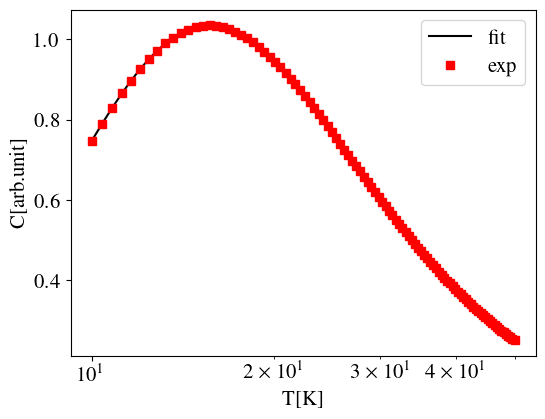

In [40]:
# 5.2. plot
plt.rcParams['figure.figsize'] = (6, 4.5)
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['font.size'] = 15

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,newtxtext,newtxmath,bm}'
plt.rcParams['font.family'] = 'TeX Gyre Termes'

plt.semilogx(kT.data, c.data, 'k-', label='fit')
plt.semilogx(kT.data, cexp.data, 'rs', label='exp')
plt.xlabel(r"T[\rm{K}]")
plt.ylabel(r"C[\rm{arb.unit}]")

plt.legend()
plt.show()


In [41]:
# 6.1. with the optimized parameters, calculate energy levels and associated wave functions
enr, psi = solve(op, B2, B4, B6)

In [42]:
# 6.2. list the states
N = op.N
print_state(N, enr, psi)
# if the format is not so tidy up, try to copy the output to normal `txt` file

      Eigenvalue       |      |4.5>      |      |4.0>      |      |3.5>      |      |3.0>      |      |2.5>      |      |2.0>      |      |1.5>      |      |1.0>      |      |0.5>      |      |0.0>      |     |-0.5>      |     |-1.0>      |     |-1.5>      |     |-2.0>      |     |-2.5>      |     |-3.0>      |     |-3.5>      |     |-4.0>      |     |-4.5>     
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        0.0000         | +0.1215+0.0000j | -0.0000+0.0000j | +0.7082+0.0000j | -0.0000+0.0000j | -0.0802+0.0000j | +0.0000+0.0000j | +0.1208+0.0000j | -0.0000+0.0000j | +0.6802+0.0000j | -0.0000+0.0000j
        0.0000         | +0.0000+0.0000j | +0.6802+0.0000j | +0.000